# Компьютерное зрение

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

### Задача

Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print(labels.shape)

(7591, 2)


In [4]:
labels.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [5]:
labels_plot = pd.read_csv('/home/konstantin/datasets/labels.csv')

In [6]:
visual = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02) # создаем "каркас"  
    
distplot = ff.create_distplot([labels_plot.real_age], ['Возраст'], bin_size=1, curve_type='normal')
distplot_data = distplot['data'] # вытягиваем данные из distplot
    
for item in distplot_data: # дропаем привязку к осям
    item.pop('xaxis', None)
    item.pop('yaxis', None)
    
for i in range(2):                              # добавляем на верхний график распределения и curve
    visual.append_trace(distplot_data[i], 1, 1) # все подряд не берем, т.к. там еще scatter, они нам не нужны

visual.add_trace(
    go.Box(x=labels_plot.real_age), # теперь на нижнем графике рисуем boxplot
    row=2, col=1
)

visual.update_layout(title={
            'text': 'Распределение возрастов в изображениях',
            'x':0.5,
            'xanchor': 'center',
            'font': {'size': 18}},
            barmode='overlay',
            showlegend=False)

visual.update_traces(opacity=0.7)

Примеры изображений:

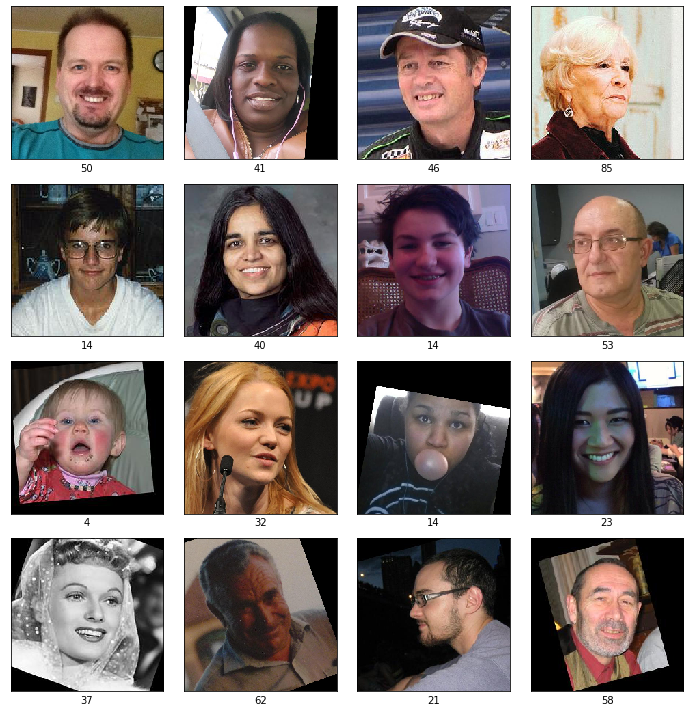

In [6]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

### Вывод:

В датасете около 7,5 тысяч изображений. Этого должно быть достаточно для обучения на предобученной модели. Однако при обучении с нуля качество, скорее всего, будет не слишком высоким. Поэтому будем обучать нейросеть на предобученной модели ResNet50. Разметка датасета выглядит корректной.

Распределение возрастов похоже на нормальное с пиком около 30 лет (статистические характеристики легко увидеть при наведении на ящик с усами), со вторым пиком ближе к нулю, что может быть связано с тем, что малолетних детей родители не могут оставить дома одних и ходят в магазин вместе с ними

Фотографии представлены, как в прямом, так и в наклоненном виде. Для аугментации можно попробовать горизонтальное отражение изображений (что может быть полезно, если фото сделано самим человеком через зеркало, например)

# 2. Обучение модели

Перенес сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        #vertical_flip=True,
        rescale=1/255.)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = False
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(1, activation='relu'))
    opt = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

Результат обучения:

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/5
2020-11-07 10:48:05.730946: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-07 10:48:06.087860: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 411.2825 - mae: 15.2158 - val_loss: 1094.1261 - val_mae: 28.5217
Epoch 2/5
178/178 - 44s - loss: 113.5769 - mae: 8.0226 - val_loss: 972.6968 - val_mae: 26.3591
Epoch 3/5
178/178 - 44s - loss: 86.4447 - mae: 6.9626 - val_loss: 242.7513 - val_mae: 11.6085
Epoch 4/5
178/178 - 43s - loss: 71.8225 - mae: 6.3614 - val_loss: 136.5518 - val_mae: 8.9961
Epoch 5/5
178/178 - 43s - loss: 58.3591 - mae: 5.7911 - val_loss: 89.7784 - val_mae: 7.1436
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 89.1247 - mae: 7.1399
Test MAE: 7.1399



```

# 3. Анализ обученной модели

Модель обучена и работает, средняя ошибка в определении возраста составляет около 7 лет. Этого достаточно для определения возрастной группы клиента, но с контролем возраста при продаже алкоголя и сигарет будут сложности, поскольку даже 18 и 17 лет - это огромная разница с точки зрения закона.

С точки зрения предметной области у меня большие сомнения в целесообразности внедрения этой модели. В первую очередь, что касается, определения возраста и предложения релевантных товаров - выглядит как попытка изобрести велосипед. Решение давно есть и работает хорошо - это бонусные карты. При получении бонусной карты покупатель заполняет анкету - мы знаем его возраст, и не приблизительно, а точно, какие товары покупает, где и по каким дням. Что касается определения возраста при продаже сигарет и алкоголя - не секрет, что многие подростки выглядят старше своего возраста. Ровно поэтому при продаже требуют паспорт. Система компьютерного зрения не застрахована от ошибок, а штраф на магазин придет большой. Кассиры и так заинтересованы в том, чтобы не продавать алкоголь детям.

На мой взгляд, гораздо полезнее была бы система из тренажерской задачи про классификацию товара. Особенно если оборудовать весы несколькими камерами с разных углов, можно добиться еще большей точности. Покупатели действительно проводят много времени, пытаясь выбрать из десяти сортов яблок и т.п. (знаю из личного опыта). Также можно контролировать заполненность полок, например. Или еще лучше - внедрить распознавание лиц на входе, если заходит замеченный в кражах персонаж - сообщать охране.